Se analizaran los datos de Grupo Financiero Inbursa, desde el 7-02-2001 hasta 4-02-2021

In [1]:
import torch, pywt, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls
import src.utilerias.seniales.dwt.dwt_multinivel as m_dwt

# Llamamos a la función para impiar la carpeta de logs antes de ejecutar el script
logs_dir = 'logs/DWT_NARNN/estandar'
logs_dir_auto_pred = 'logs/DWT_NARNN/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
from src.modelos.auto_regresivo.entrenamientos.entrenamiento import Entrenamiento as entr
from src.modelos.auto_regresivo.NARNN.NARNN import NARNN
criterion = nn.MSELoss()

In [3]:
# Abrir el archivo CSV en modo lectura

# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
# DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

# ACTINVRB
DATOS = 'datos\_nacionales\entidades financieras\ACTINVRB\_030116_ 311223.csv' 
# BOLSAA
#DATOS = 'datos\_nacionales\entidades financieras\BOLSAA\_030116_311223.csv'
# GBMO
#DATOS = 'datos\_nacionales\entidades financieras\GBMO\_030116_311223.csv'
# GENTERA
#DATOS = 'datos\_nacionales\entidades financieras\GENTERA\_030116_311223.csv'
# GFINBURO
#DATOS = 'datos\_nacionales\entidades financieras\GFINBURO\_030116_311223.csv'
# GFNORTEO
#DATOS = 'datos\_nacionales\entidades financieras\GFNORTEO\_030116_311223.csv'
# GNP
#DATOS = 'datos\_nacionales\entidades financieras\GNP\_030116_311223.csv'
# Q
#DATOS = 'datos\_nacionales\entidades financieras\Q\_030116_311223.csv'

Longitud de la entrada: 415


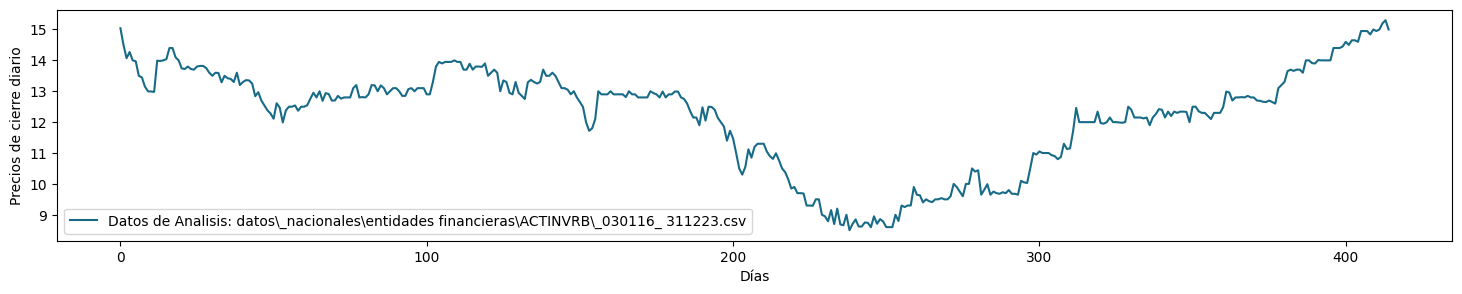

In [4]:
cierre = rd.leer_archivo(DATOS)
#se convierten todos los valores a flotantes
cierre = cierre.astype(float)

# Crear un gráfico de línea con los valores de x, y
print(f"Longitud de la entrada: {len(cierre)}")
plt.figure(figsize=(18, 3))
plt.plot(cierre, label=f"Datos de Analisis: {DATOS}", color='#176B87')
plt.xlabel('Días')
plt.ylabel('Precios de cierre diario')
plt.legend()
plt.show()

# Eleccion de Ondícula Madre

Se elige las ondículas madre dependiendo de las características de la serie de tiempo que se va a análizar. Para series que impliquen cambios suaves y no repentinos es recomendable usar Haar ya que responde bien a estos cambios.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada.

Longitud de la entrada de cA: 213


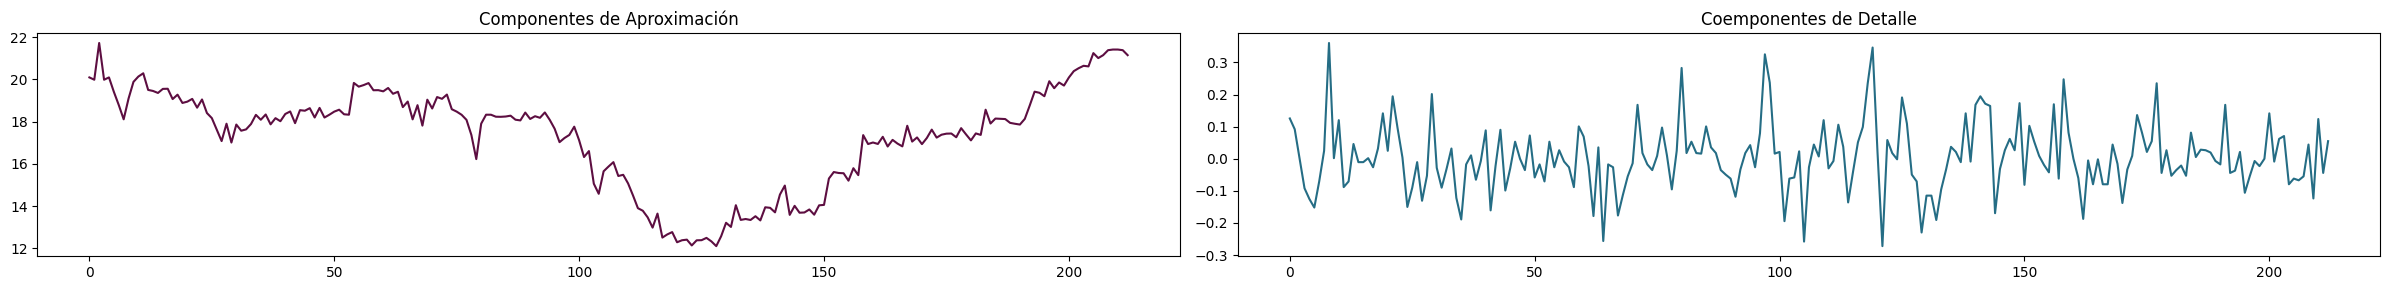

In [5]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
# print(pywt.wavelist()) imprime la lista de wavelets de la biblioteca
wavelet = 'bior3.5'
mode = pywt.Modes.symmetric #constant, smooth, antireflect
wavelet = pywt.Wavelet(wavelet)
(cA, cD) = pywt.dwt(cierre.tolist(), wavelet, mode=mode)
print(f"Longitud de la entrada de cA: {len(cA)}")

plt.figure(figsize=(24, 3))
aprox_coef = True
index = 1

for _ in [cA, cD]:
    plt.subplot(1, 2, index)
    plt.plot(_, color='#5D0E41' if aprox_coef else '#256D85')
    plt.title('Componentes de Aproximación' if aprox_coef else 'Coemponentes de Detalle')
    aprox_coef = False
    index = index + 1

plt.tight_layout()
plt.show()

1. Se dividen los precios de cierre semanal en el conjunto de pruebas (70%) y un conjunto de pruebas (30%). Se realiza la separacion del conjunto de entrenamiento y el de prueba.

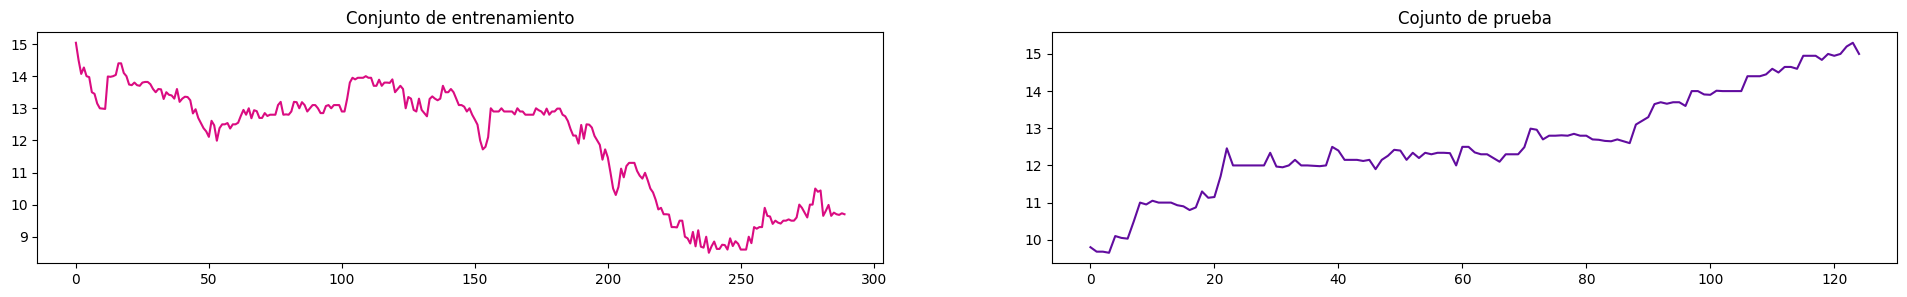

In [6]:
#Se realiza el proceso 5 veces
cierre_e = cierre[:int(len(cierre) * 0.7)]#cierre entrenamiento len 182
cierre_p = cierre[int(len(cierre) * 0.7):]#cierre prueba len 78

# # Muestreo aleatorio
# # Genera índices aleatorios únicos y ordenados
# indices_aleatorios = np.sort(np.random.choice(len(cierre), size=int(0.3 * len(cierre)) + 8, replace=False))
# # Selecciona los elementos correspondientes a los índices ordenados
# cierre_p = cierre[indices_aleatorios]
# # Calcula los índices del 70% restante (complemento del conjunto del 30%)
# indices_restantes = np.setdiff1d(np.arange(len(cierre)), indices_aleatorios)
# # Selecciona los elementos correspondientes a los índices restantes
# cierre_e = cierre[indices_restantes]

plt.figure(figsize=(24, 3))
index = 1
aprox_coef = True
for _ in [cierre_e, cierre_p]:
    plt.subplot(1, 2, index)
    plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Conjunto de entrenamiento' if aprox_coef else 'Cojunto de prueba')
    aprox_coef = False
    index = index + 1

2. Se descompone el conjunto de entrenamiento con la DWT, en coeficientes de aproximación A(t) y detalle D(t). Usamos un nivel de descomposición de 6 y extraemos los componentes A5, D5, D4, D3, D2, D1.

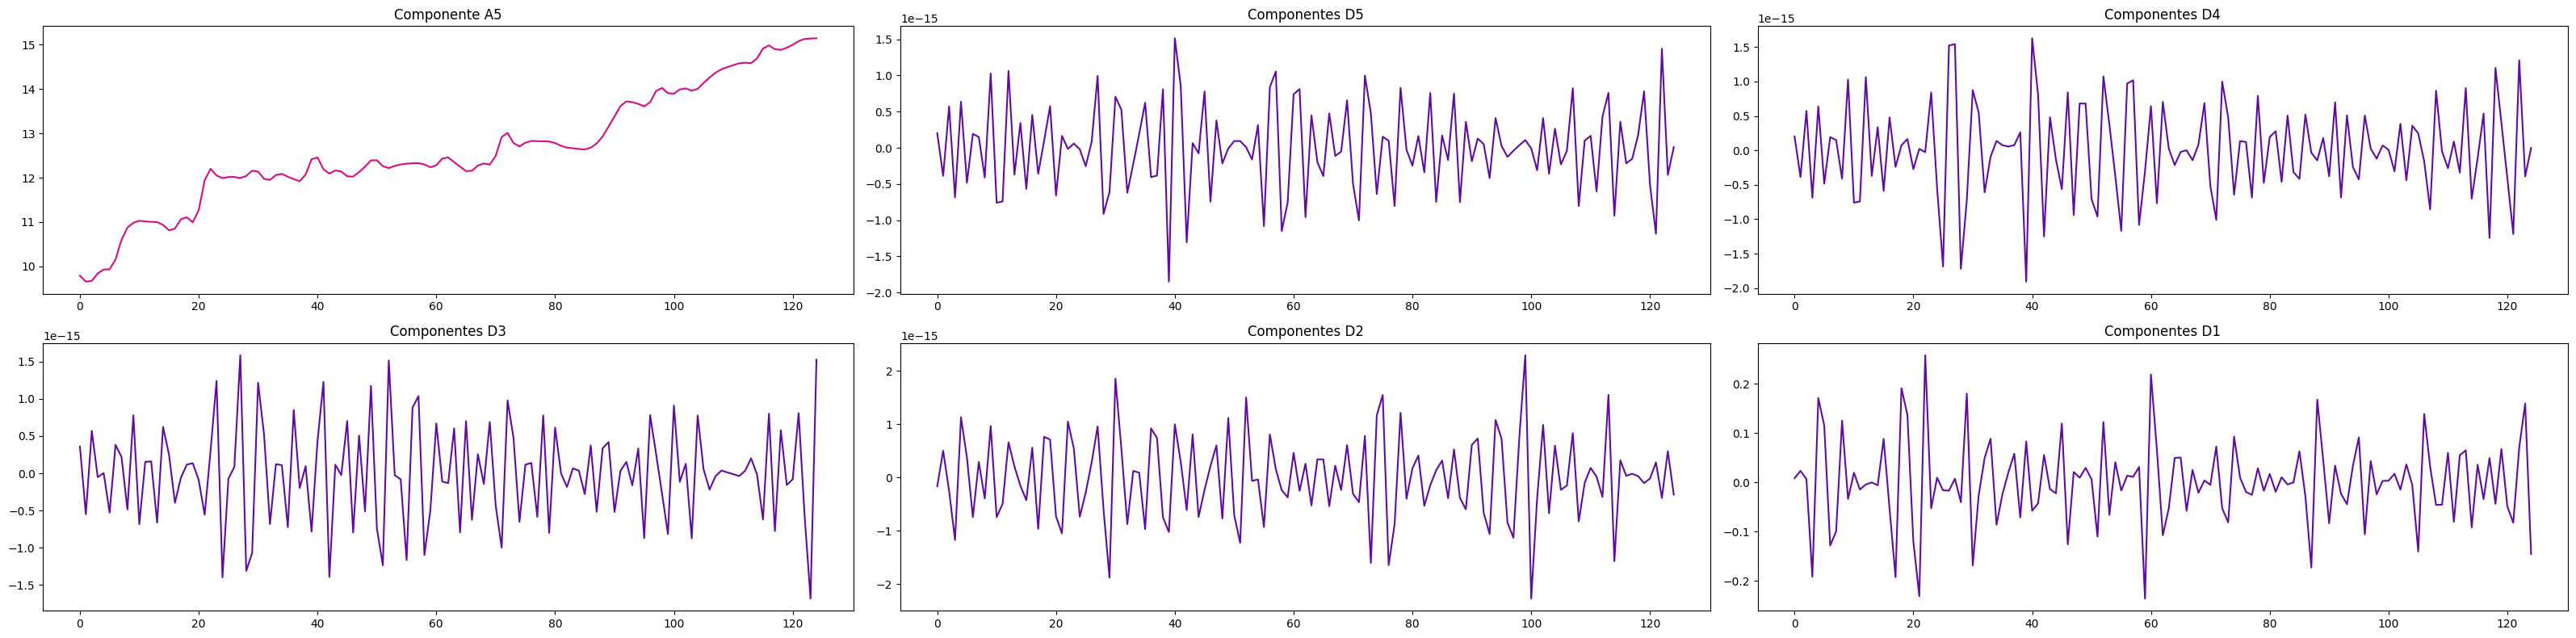

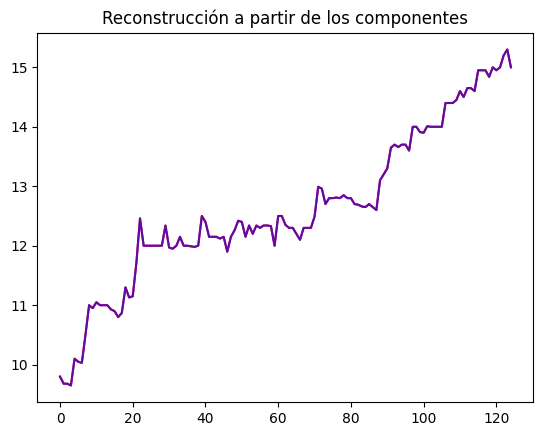

In [7]:
mode = 'symmetric'
components = m_dwt.multilevel_dwt(cierre, wavelet, 5, mode)
components_e = m_dwt.multilevel_dwt(cierre_e, wavelet, 5, mode) # componentes de entrenamiento 
components_p = m_dwt.multilevel_dwt(cierre_p, wavelet, 5, mode) #componentes de prueba

plt.figure(figsize=(32, 8))
aprox_coef = True
index = 1

c = 6

for _ in components_p:
    plt.subplot(2, 3, index)
    plt.plot(range(len(_)), _, color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Componente A5' if aprox_coef else f'Componentes D{c}')
    aprox_coef = False
    index = index + 1
    c = c- 1

plt.tight_layout()
plt.show()

o_data = 0 #original data
for c in components_p:
    o_data =  o_data + c

plt.plot(range(len(o_data)),o_data, color='#DA0C81')
plt.plot(range(len(cierre_p)),o_data, color='#610C9F')
plt.title('Reconstrucción a partir de los componentes')
plt.show()

3. Normalizamos los componentes.

In [8]:
#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
components_e_n = [utls.normalizar(vect) for vect in components_e] # componentes de entrenamiento normalizados
components_p_n = [utls.normalizar(vect) for vect in components_p] # componentes de prueba normalizados len 78

#Se concatenan los ultimo 8 elementos del conjunto de entrenamiento para predecir el primero del conjunto de prueba
# ahora cada uno de los arreglos dentro de components_p y components_p_n tiene forma (84,)
for i in range(len(components_p_n)):
    components_p[i] = np.concatenate((components_e[i][-8:],components_p[i]))
    components_p_n[i] = np.concatenate((components_e_n[i][-8:],components_p_n[i]))

# Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
# componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena

4. Construimos seis NARNN para cada componente. El número de semanas anteriores que alimentaran a la red será de 8.

In [9]:
networks = []
COMPONENTES = ['A5', 'D5', 'D4', 'D3', 'D2', 'D1']
time_steps = 8

for nombre in COMPONENTES:
    red = NARNN(t_entrada=8, t_salida=1, nombre="DWT_NARNN_" + nombre)
    if(nombre in [ "D2", "D1"]):
        red.load_state_dict(torch.load(f'redes/DWT_NARNN/estandar/ACTINVRB/finales/red_{nombre}_lr0.017_e60.pth'))
    elif(nombre in [ "D5", "D4", "D3"]):
        red.load_state_dict(torch.load(f'redes/DWT_NARNN/estandar/ACTINVRB/finales/red_{nombre}_lr0.02_e30.pth'))
    elif (nombre in [ "A5"]):
        red.load_state_dict(torch.load(f'redes/DWT_NARNN/estandar/ACTINVRB/finales/red_{nombre}_lr0.04_e30.pth'))
    red.eval()
    networks.append(red)

#entradas ya procesadas
entrenamiento_8_1 = [[],[],[],[],[],[]]
prueba_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
for e in range(6):
    entrenamiento_8_1[e] = utls.corrimiento_t_1(components_e_n[e],9) # list(tensor[()]*) una lista de 174 tensores con 9 elementos cada uno
    prueba_8_1[e] = utls.corrimiento_t_1(components_p_n[e],9) # list(tensor[()]*) una lista de 78 tensores con 9 elementos cada uno

# esta configuración hace que se prediga a partir de los 8 primeros datos y se haga un corrimiento de 1 hasta predecir con todos los elementos del conjunto
# de entrenamiento y prueba, es decir hasta que predice un elemento mas con el ultimo subarreglo, al final se tendrán 174 y 78 predicciones

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15668\3102533210.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  red.load_state_dict(torch.load(f'redes/DWT_NARNN/estandar/

5. Entrenamos las 5 NARNN.

# Entrenamiento estandar 

In [10]:
#Se define el número de epocas
EPOCAS = 20
LR = 0.1 #0.017/30 ideal para D5

In [11]:
# Se realiza el entrenamiento de cada una de las redes y se guarda el modelo ya entrenado

# entr_A5 = entr(networks[0],0,writer_dir=logs_dir)
# entr_A5.entrena_lm(entrenamiento_8_1[0],EPOCAS,lr=0.01,λ=0.1,e_predictivo=False)
# torch.save(networks[0].state_dict(), 'redes/DWT_NARNN/red_A1_ACTINVRB.pth') #Salvamos el estado actual del modelo

# # nombre de los datos
# str_conj_datos = 'ACTINVRB'
# params = f'lr{LR}_e{EPOCAS}'

# # Iterar sobre las redes y los entrenamientos correspondientes --f'red_A5_{params}.pth',
# for i, (net, entrenamiento, nombre_guardado) in enumerate(zip(networks[2:4], entrenamiento_8_1[2:4], [f'red_A5_{params}.pth', f'red_D5_{params}.pth', f'red_D4_{params}.pth', f'red_D3_{params}.pth', f'red_D2_{params}.pth', f'red_D1_{params}.pth'][2:4])):
#     # Entrenar la red
#     entr_net = entr(net, i, writer_dir=logs_dir)
#     entr_net.entrena_lm(entrenamiento, EPOCAS, lr=LR, λ=0.1, e_predictivo=False)
    
#     # Guardar el estado actual del modelo
#     torch.save(net.state_dict(), f'redes/DWT_NARNN/estandar/{str_conj_datos}/{nombre_guardado}')
    
#     # Cerrar el escritor
#     entr_net.cerrar_escritor()


# Predicción del conjunto de entrenamiento
usando los datos originales para la recurrencia

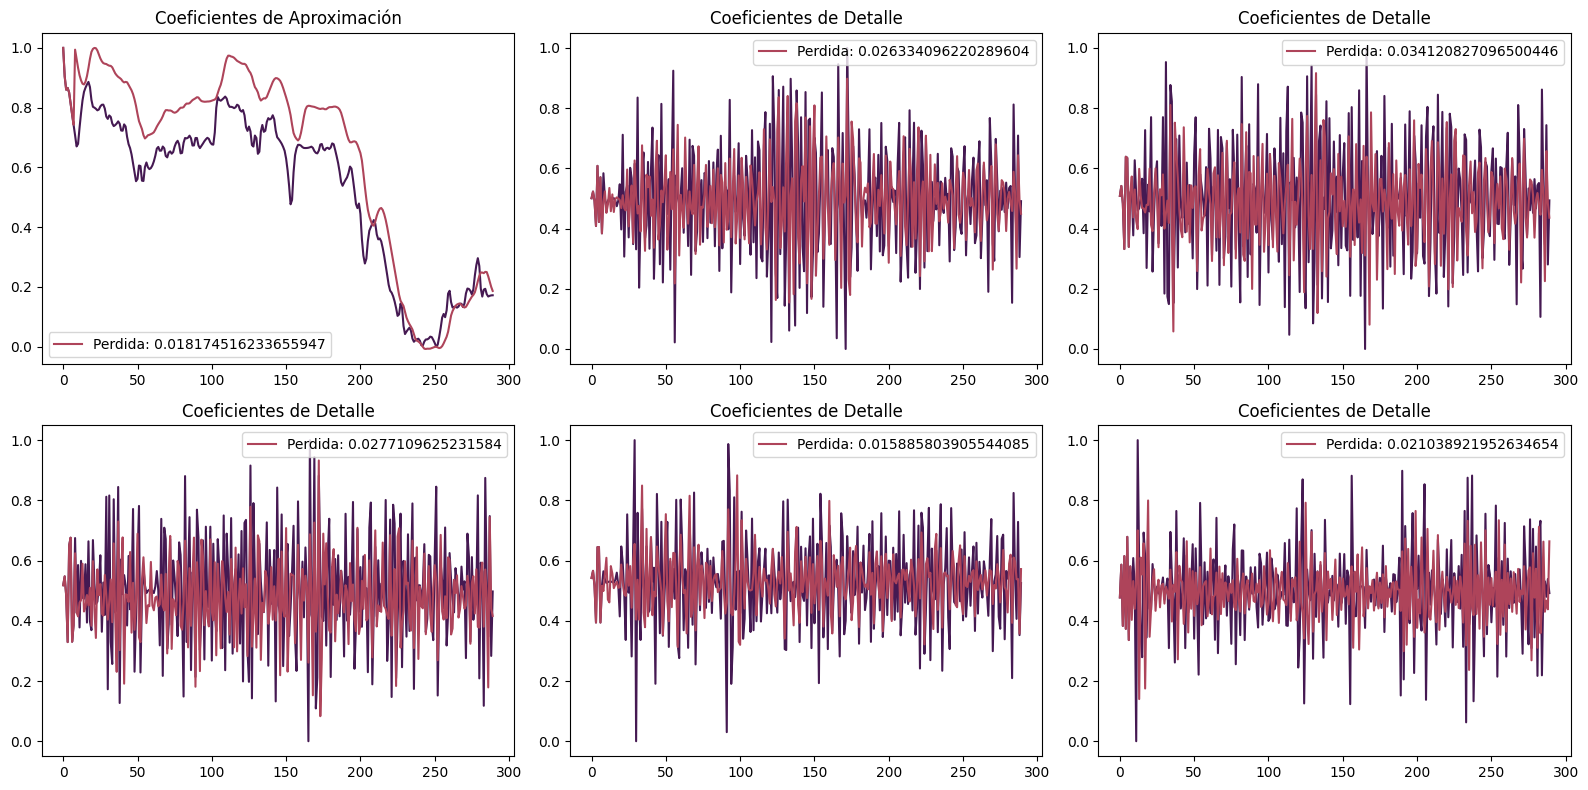

In [12]:
#Se grafica el conjunto de entrenamiento
perdidas = []
predicciones = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1

for _ in range(len(components_e_n)):
    predicciones.append(utls.genera_prediccion_1(entrenamiento_8_1[_],networks[_],8))
    perdidas.append(criterion(predicciones[_], torch.tensor(components_e_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_e_n[_], color = '#451952') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(predicciones[_].detach().numpy(), label = f"Perdida: {float(perdidas[_])}", color='#AE445A')#label=f"Datos de Analisis: {DATOS}",
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

# Predicción del conjunto de prueba
usando los datos originales para la recurrencia

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15668\1756454360.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


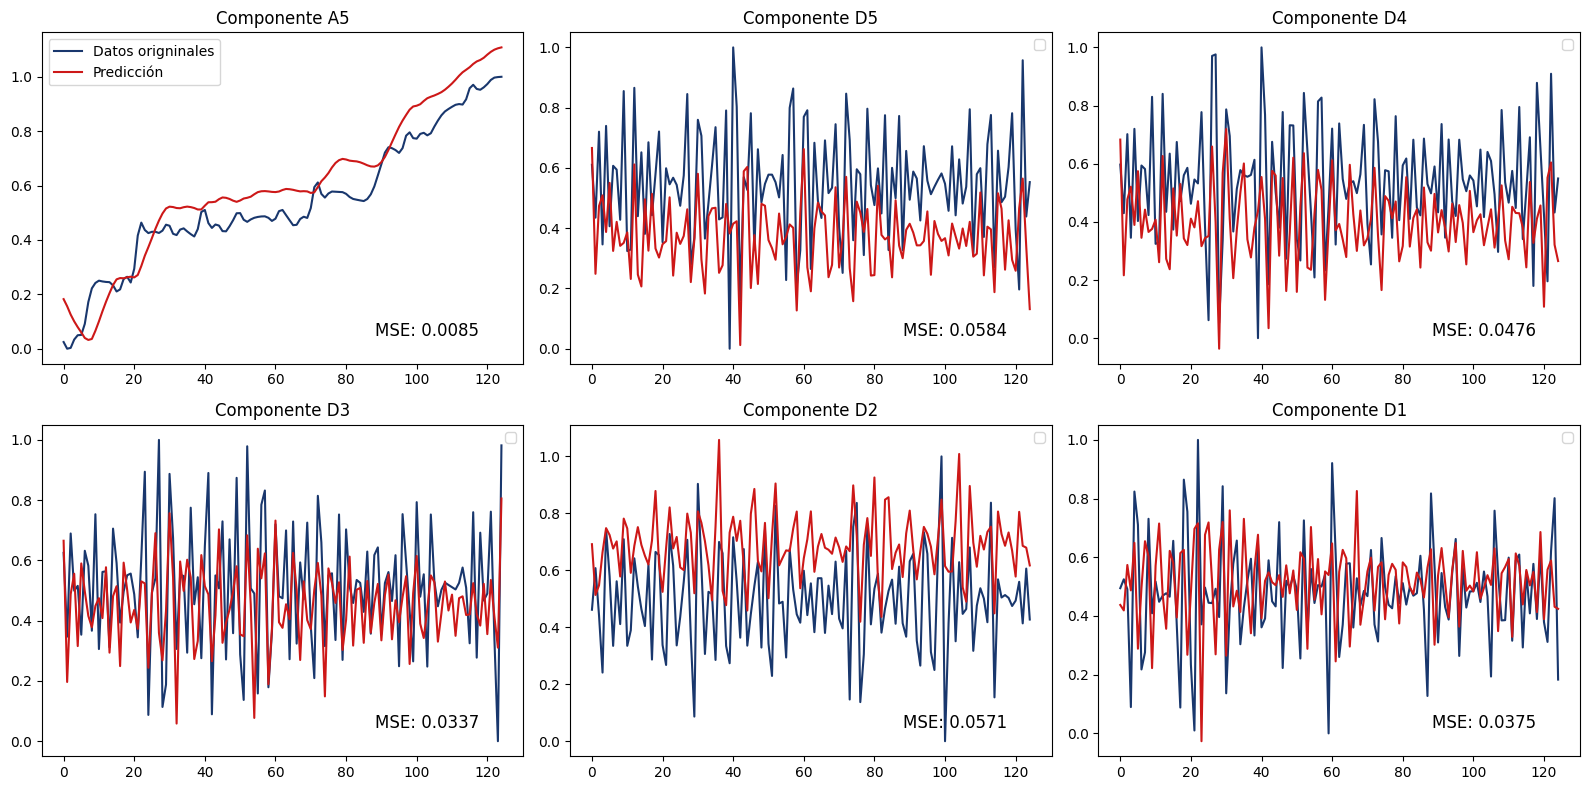

Perdidas: [tensor(0.0085, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0584, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0476, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0337, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0571, dtype=torch.float64, grad_fn=<MseLossBackward0>), tensor(0.0375, dtype=torch.float64, grad_fn=<MseLossBackward0>)]


In [13]:
perdidas = []
predicciones = []
plt.figure(figsize=(16, 8))

aprox_coef = True
index = 1
c = 6

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_prediccion_1(prueba_8_1[_],networks[_],8))
    perdidas.append(criterion(predicciones[_], torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_][time_steps:], label= "Datos origninales" if aprox_coef else "", color = '#19376D') #color='#DA0C81' if aprox_coef else '#610C9F')
    plt.plot(predicciones[_][time_steps:].detach().numpy(), label = "Predicción" if aprox_coef else "", color='#CD1818')#label=f"Datos de Analisis: {DATOS}",
    
    plt.title('Componente A5' if aprox_coef else f'Componente D{c}')
    aprox_coef = False
    mse_e = float(perdidas[_])
    plt.text(0.8, 0.1, f"MSE: {round(mse_e,4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    index = index + 1
    c = c - 1
    plt.legend()

plt.tight_layout()
plt.show()

print("Perdidas: " + str(perdidas))

# Reconstrucción del conjunto de prueba

In [14]:
# Se eliminan los 8 ultimos datos del conjunto de entrenamiento
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][time_steps:]

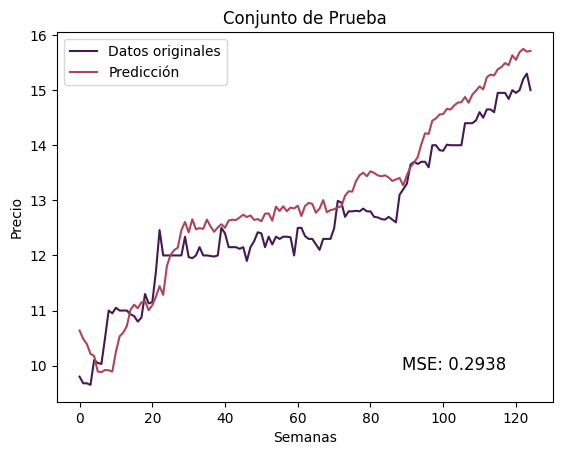

Perdida: 0.29382650387329684


In [15]:
predicciones_d = []
i=0
for vect in predicciones:
    # le quitamos los primeros time_steps elementos al conjunto: components_p[i][time_steps:]
    # para que no interfiera en la normalización
    predicciones_d.append(utls.desnormalizar(vect.detach().numpy(),np.max(components_p[i][time_steps:]),np.min(components_p[i][time_steps:])))
    i=i+1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d

rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec
rec = torch.tensor(A5_rec) + torch.tensor(D5_rec) + torch.tensor(D4_rec) + torch.tensor(D3_rec) + torch.tensor(D2_rec) + torch.tensor(D1_rec)
#le quitamos los primeros 8 elementos que le agregamos para predecir
rec = rec.detach().numpy()
plt.plot(cierre_p, color = '#451952', label = 'Datos originales') #Señal original
plt.plot(rec, color='#AE445A', label = 'Predicción') #Señal predicha
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = float(criterion(torch.tensor(rec), torch.tensor(cierre_p)))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.legend()
plt.show()

print(f"Perdida: {float(criterion(torch.tensor(rec), torch.tensor(cierre_p)))}")

# Evaluación de desempeño

In [16]:
#componentes desnormalizados contra predicciones desnormalizadas.
df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p] + [c[time_steps:] for c in components_p])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec] + predicciones_d)))

# Mostramos el DataFrame con métricas
print(df_metricas) 

                              RMSE        MAPE    DS
Reconstrucción de c_prueba  0.5421    3.895321  77.6
Componente A5               0.5234    3.788553  57.6
Componente D5               0.0000  174.387150  55.2
Componente D4               0.0000  154.766147  65.6
Componente D3               0.0000  107.227918  68.0
Componente D2               0.0000  204.159303  66.4
Componente D1               0.0987  445.400440  67.2


# Generamos el entrenamiento predictivo

In [17]:
# networks[0].load_state_dict(torch.load('redes/DWT_NARNN/auto_predictiva/red_A5_datos_originales_pred.pth'))
# networks[0].eval()

# for i in range(6):
#     model_path = f'redes/DWT_NARNN/auto_predictiva/red_{["A5", "D5", "D4", "D3", "D2", "D1"][i]}_datos_originales_pred.pth'
#     networks[i].load_state_dict(torch.load(model_path))
#     networks[i].eval()


In [18]:
# referencia: entr.entrena_LM_pred(networks[0],0,entrenamiento_8_1,15 ,lr=0.5,λ =0.1,batch_size=8,decay_factor=5) #EPOCAS

# entr_A5 = entr(networks[0],0, logs_dir_auto_pred)
# entr_A5.entrena_lm(entrenamiento_8_1[0],EPOCAS,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[0].state_dict(), 'redes/DWT_NARNN/red_A5_pred') #Salvamos el estado actual del modelo

# # Iterar sobre las redes y los entrenamientos correspondientes
# for i, (net, entrenamiento, nombre_guardado) in enumerate(zip(networks, entrenamiento_8_1, [f'red_A1_{str_conj_datos}_pred.pth', f'red_D5_{str_conj_datos}_pred.pth', f'red_D4_{str_conj_datos}_pred.pth', f'red_D3_{str_conj_datos}_pred.pth', f'red_D2_{str_conj_datos}_pred.pth', f'red_D1_{str_conj_datos}_pred.pth'])):

#     # Entrenar la red
#     entr_net = entr(net, i, logs_dir_auto_pred)
#     entr_net.entrena_lm(entrenamiento,EPOCAS,lr=LR,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
    
#     # Guardar el estado actual del modelo
#     torch.save(net.state_dict(), f'redes/DWT_NARNN/auto_predictiva/{nombre_guardado}')
    
#     # Cerrar el escritor
#     entr_net.cerrar_escritor()


# Predicción del conjunto de prueba
usando los datos predictivos para la recurrencia

6. Predict  the  future  price  for  each  point  in  the  testing data set as follows:
a) Decompose its preceding price data as described in step 2.  
b) Normalize the decomposed features using Eq. (3). 
c) Predict one step for each component. (El contenido se guarda en el arreglo 'predicciones')
d) De-normalize and aggregate the predicted values. 
e) Repeat steps a, b and c until all the testing dataset 
points are forecasted.

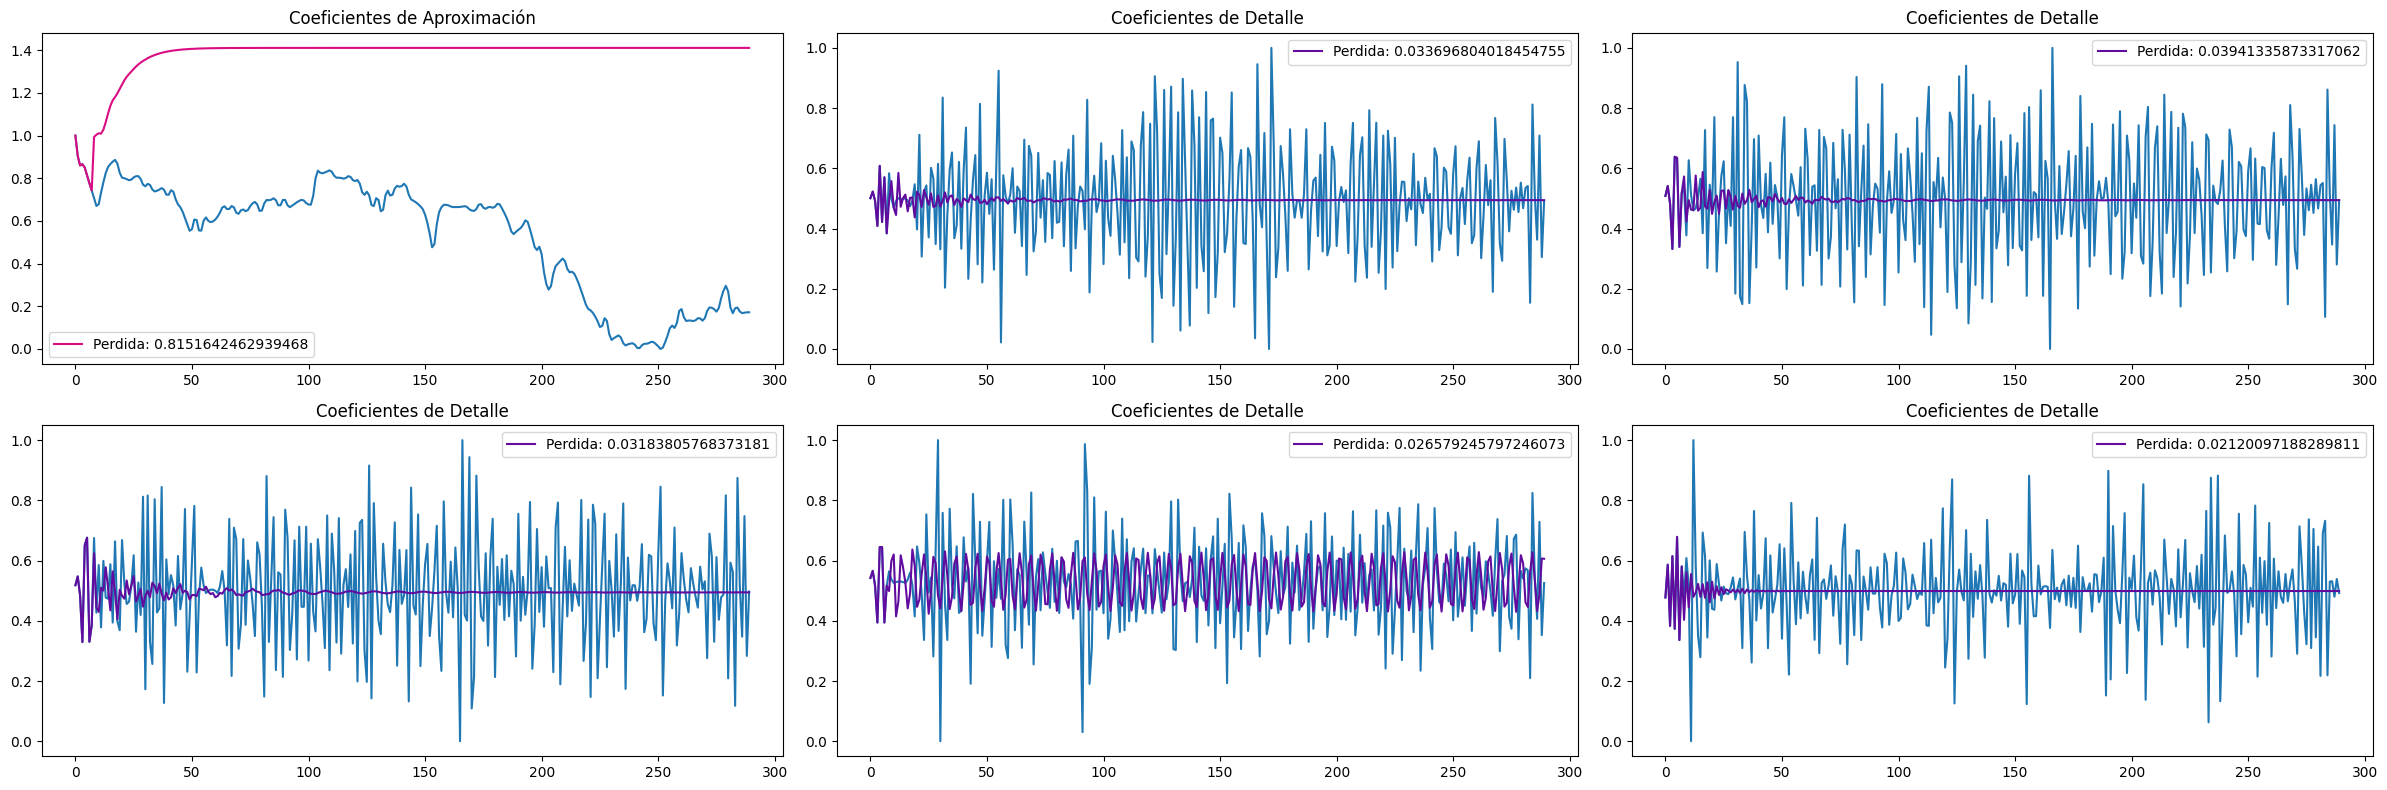

Perdidas predictivas: [tensor(0.8152, dtype=torch.float64), tensor(0.0337, dtype=torch.float64), tensor(0.0394, dtype=torch.float64), tensor(0.0318, dtype=torch.float64), tensor(0.0266, dtype=torch.float64), tensor(0.0212, dtype=torch.float64)]


In [19]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []

for _ in range(len(components_e_n)):
    predicciones.append(utls.genera_pred_auto_predictiva(components_e_n[_],time_steps,networks[_]))
    perdidas_predictivas.append(criterion(torch.tensor(predicciones[_]), torch.tensor(components_e_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_e_n[_])
    plt.plot(predicciones[_],  label = f"Perdida: {float(perdidas_predictivas[_])}", color='#DA0C81' if aprox_coef else '#610C9F')
    plt.title('Coeficientes de Aproximación' if aprox_coef else 'Coeficientes de Detalle')
    aprox_coef = False
    plt.legend()
    index = index + 1

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15668\1148654574.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


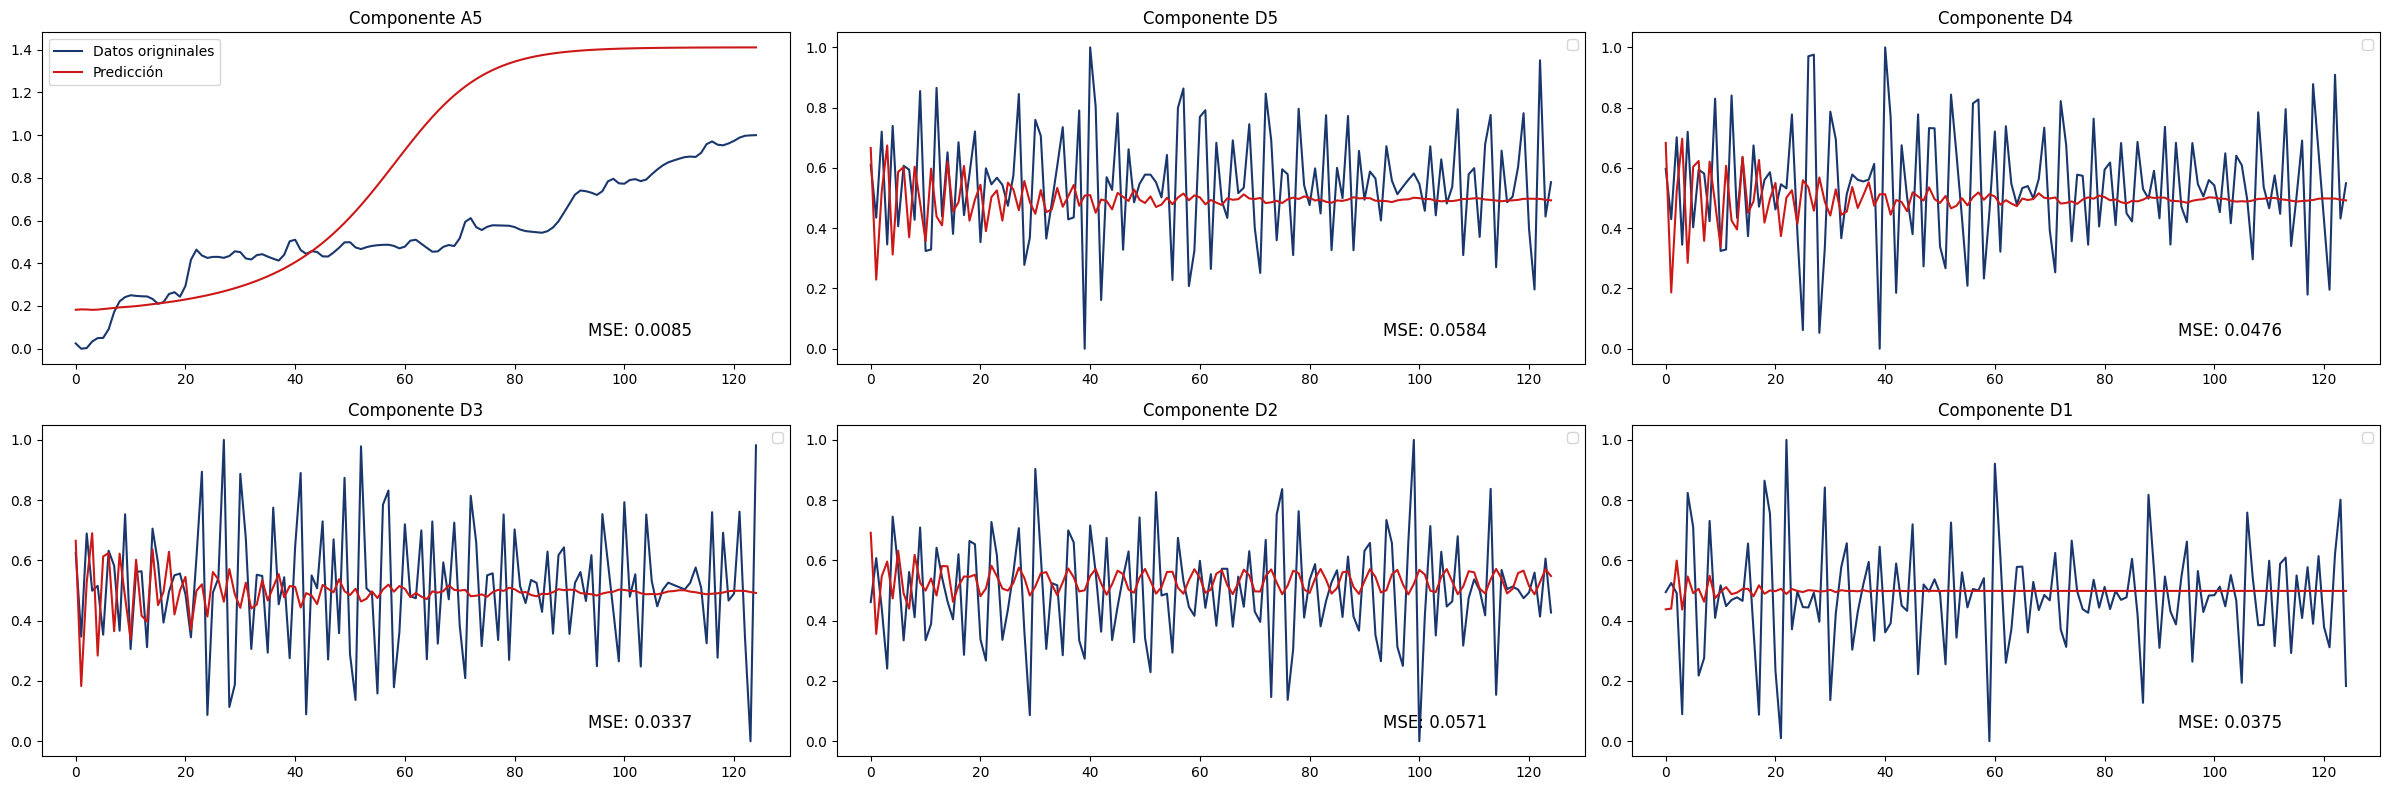

Perdidas predictivas: [tensor(0.2061, dtype=torch.float64), tensor(0.0372, dtype=torch.float64), tensor(0.0421, dtype=torch.float64), tensor(0.0404, dtype=torch.float64), tensor(0.0317, dtype=torch.float64), tensor(0.0289, dtype=torch.float64)]


In [20]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
c = 6
predicciones = []

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_pred_auto_predictiva(components_p_n[_],time_steps,networks[_]))
    perdidas_predictivas.append(criterion(torch.tensor(predicciones[_]), torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_][time_steps:], label= "Datos origninales" if aprox_coef else "", color = '#19376D')
    plt.plot(predicciones[_][time_steps:], label = "Predicción" if aprox_coef else "", color='#CD1818')
    plt.title('Componente A5' if aprox_coef else f'Componente D{c}')
    aprox_coef = False
    mse_e = float(perdidas[_])
    plt.text(0.8, 0.1, f"MSE: {round(mse_e,4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    index = index + 1
    c = c - 1
    plt.legend()

plt.tight_layout()
plt.show()

print("Perdidas predictivas: " + str(perdidas_predictivas))

# Reconstruimos la señal original usando el conjunto de prueba

In [21]:
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15668\3137173845.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse_e = float(criterion(torch.tensor(rec), torch.tensor(cierre_p)))


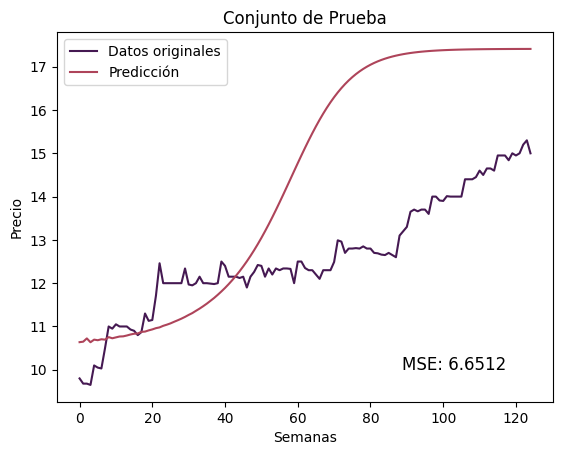

Perdida: 6.651187341263916


C:\Users\Miguel\AppData\Local\Temp\ipykernel_15668\3137173845.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Perdida: {float(criterion(torch.tensor(rec), torch.tensor(cierre_p)))}")


In [22]:
predicciones_d = []
i=0
for vect in predicciones:
    # le quitamos los primeros time_steps elementos al conjunto: components_p[i][time_steps:]
    # para que no interfiera en la normalización
    predicciones_d.append(utls.desnormalizar(vect,np.max(components_p[i][time_steps:]),np.min(components_p[i][time_steps:])))
    i=i+1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d

rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec
rec = torch.tensor(A5_rec) + torch.tensor(D5_rec) + torch.tensor(D4_rec) + torch.tensor(D3_rec) + torch.tensor(D2_rec) + torch.tensor(D1_rec)

plt.plot(cierre_p, color = '#451952', label = 'Datos originales') #Señal original
plt.plot(rec, color='#AE445A', label = 'Predicción') #Señal predicha
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = float(criterion(torch.tensor(rec), torch.tensor(cierre_p)))
plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

print(f"Perdida: {float(criterion(torch.tensor(rec), torch.tensor(cierre_p)))}")

# Evaluación de desempeño

In [23]:
#componentes desnormalizados contra predicciones desnormalizadas.
df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p] + [c[time_steps:] for c in components_p])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec] + predicciones_d)))

# Mostramos el DataFrame con métricas
print(df_metricas) 

                              RMSE        MAPE    DS
Reconstrucción de c_prueba  2.5790   16.083165  60.8
Componente A5               2.5705   16.032430  58.4
Componente D5               0.0000  103.209819  45.6
Componente D4               0.0000  101.234381  43.2
Componente D3               0.0000   92.927896  44.8
Componente D2               0.0000  106.261748  48.0
Componente D1               0.0867  166.882216  65.6


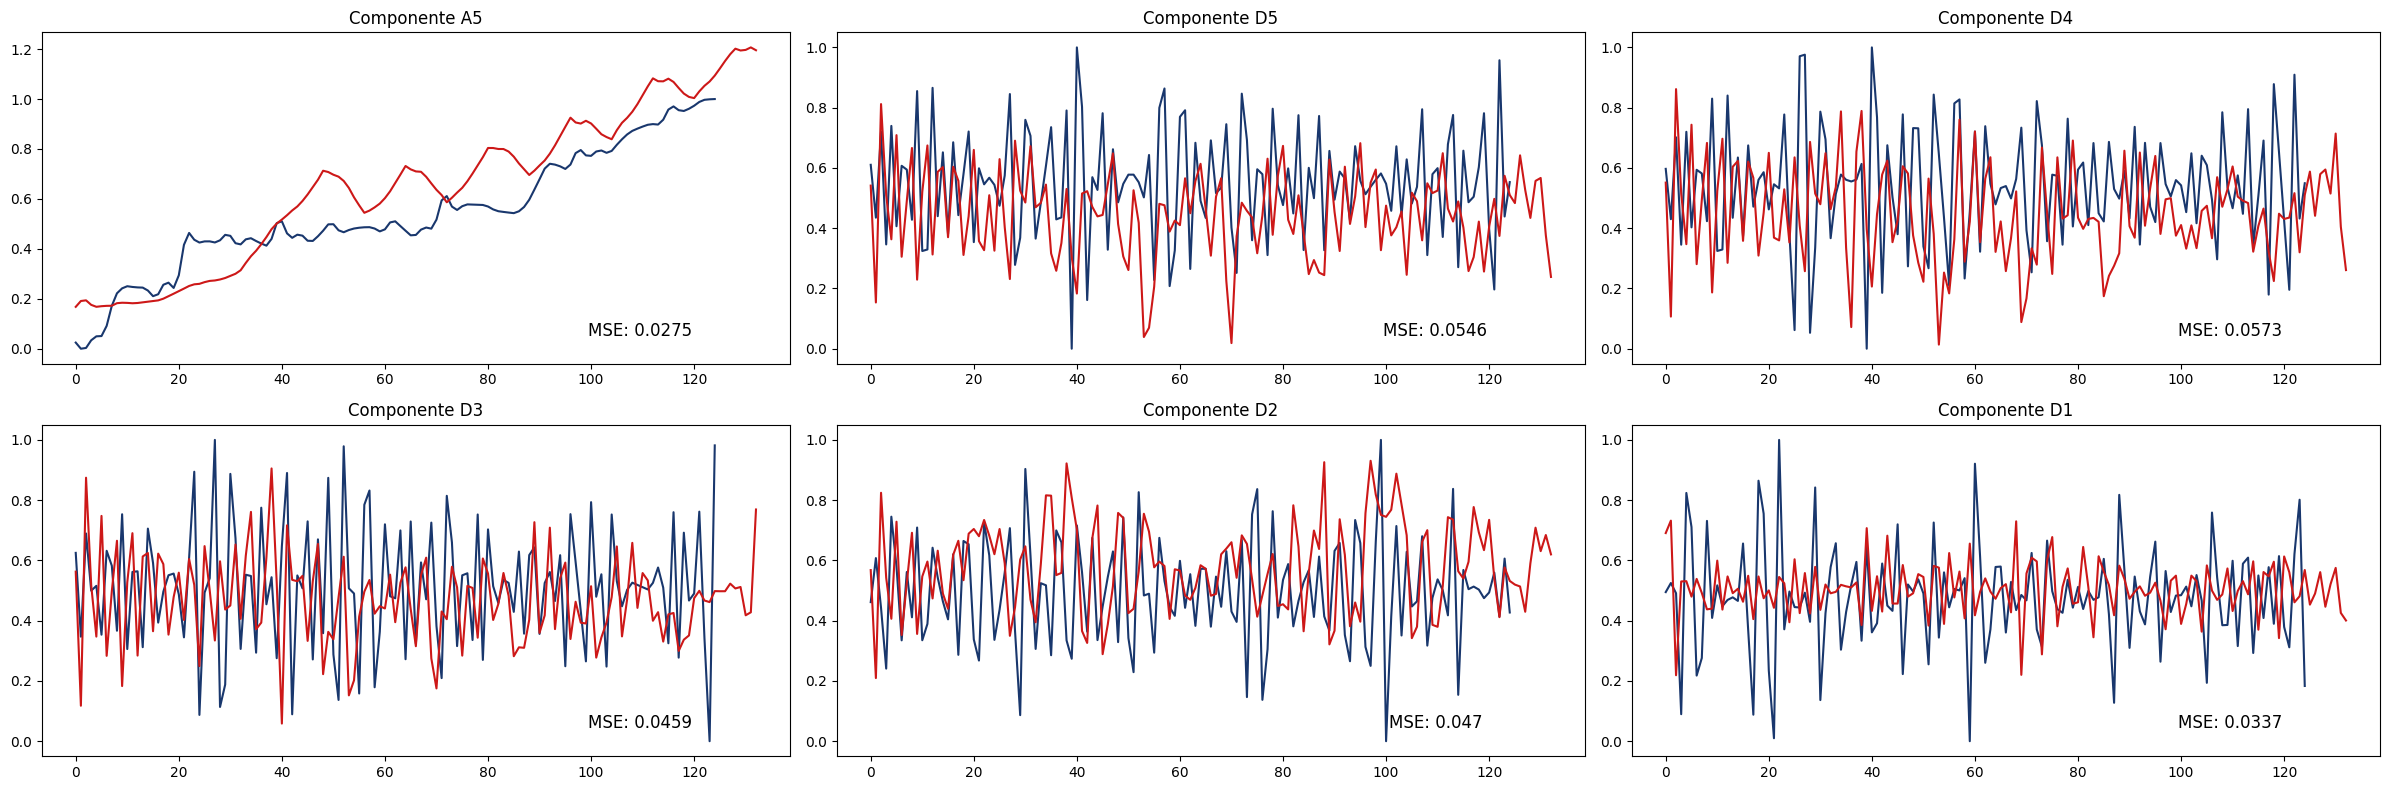

In [24]:
perdidas_predictivas = []
plt.figure(figsize=(24, 8))

aprox_coef = True
index = 1
predicciones = []
c=6

for _ in range(len(components_p_n)):
    predicciones.append(utls.genera_pred_auto_predictiva(components_p_n[_],time_steps,networks[_],correccion=True))
    perdidas_predictivas.append(criterion(torch.tensor(predicciones[_]), torch.tensor(components_p_n[_])))
    plt.subplot(2, 3, index)
    plt.plot(components_p_n[_][time_steps:], color = '#19376D')
    plt.plot(predicciones[_], color ='#CD1818')
    plt.title('Componente A5' if aprox_coef else f'Componente D{c}')
    aprox_coef = False
    plt.text(0.8, 0.1, f"MSE: {round(float(perdidas_predictivas[_]),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
    index = index + 1
    c=c-1

plt.tight_layout()
plt.show()

#al conjunto de predicciones le quitamos los ultimos 8 elementos del conjunto de entrenamiento
for i in range(len(predicciones)):
    predicciones[i] = predicciones[i][8:]

predicciones_d = []
i=0
for vect in predicciones:
    # le quitamos los primeros time_steps elementos al conjunto: components_p[i][time_steps:]
    # para que no interfiera en la normalización
    predicciones_d.append(utls.desnormalizar(vect,np.max(components_p[i][time_steps:]),np.min(components_p[i][time_steps:])))
    i=i+1

(A5_rec, D5_rec, D4_rec, D3_rec, D2_rec, D1_rec) = predicciones_d
rec = A5_rec + D5_rec + D4_rec + D3_rec + D2_rec + D1_rec

#(A5_p_n, D5_p_n, D4_p_n, D3_p_n, D2_p_n, D1_p_n) = [c[8:] for c in components_p_n]
#cierre_p_n = A5_p_n + D5_p_n + D4_p_n + D3_p_n + D2_p_n + D1_p_n

cierre_p_n = utls.normalizar(cierre_p)
 # se toma el minimo y el maximo de cierre_p para que la proporcion quede igual
rec_n = utls.normalizar(rec,_min=np.min(cierre_p),_max=np.max(cierre_p))

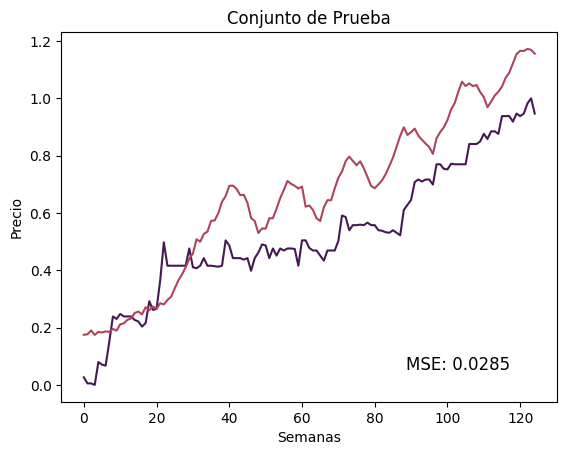

                              RMSE          MAPE    DS
Reconstrucción de c_prueba  0.1687  6.287006e+14  58.4
Componente A5               0.1710  6.634185e+14  55.2
Componente D5               0.2411  2.335287e+15  60.0
Componente D4               0.2468  2.095618e+15  60.0
Componente D3               0.2211  1.541426e+15  64.8
Componente D2               0.2236  2.523481e+15  54.4
Componente D1               0.1894  1.541234e+15  51.2


In [25]:
plt.plot(cierre_p_n, color = '#451952', label = 'Datos originales')
plt.plot(rec_n, color='#AE445A', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
mse_e = float(criterion(torch.tensor(rec_n), torch.tensor(cierre_p_n)))
mse_e_values = utls.mse_elemental(cierre_p_n, rec_n)
#ks_statistic, ks_p_value = ks_2samp(cierre_p, rec)

#intervalo_superior = rec_n + 1.96 * utls.rmse(cierre_p, rec)
#intervalo_inferior = rec_n - 1.96 * utls.rmse(cierre_p, rec)

plt.text(0.8, 0.1, f"MSE: {round(mse_e,4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)
#plt.text(0.8, 0.05, f"KS: {round(ks_statistic,4)}, Valor p: {round(ks_p_value,4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

#plt.fill_between(range(len(rec)), intervalo_inferior, intervalo_superior, color='gray', alpha=0.2, label='Intervalo de predicción (95%)')
plt.show()

#omitimos los primeros 8 datos (ultimos 8 del conjunto de entrenamiento) que agregamos en un inicio
df_metricas = utls.genera_metricas(dict(zip(['c_prueba']+COMPONENTES,[cierre_p_n] + [c[time_steps:] for c in components_p_n])),
                                   dict(zip(['c_prueba']+COMPONENTES,[rec_n] + predicciones)))

# Mostramos el DataFrame con métricas
print(df_metricas)

[0.008 0.024 0.04  0.04  0.04  0.048 0.056 0.056 0.064 0.072 0.08  0.104
 0.104 0.104 0.112 0.112 0.128 0.128 0.128 0.136 0.136 0.136 0.144 0.144
 0.144 0.144 0.16  0.16  0.16  0.168 0.168 0.168 0.168 0.168 0.168 0.168
 0.168 0.168 0.168 0.176 0.176 0.176 0.176 0.176 0.176 0.176 0.176 0.176
 0.176 0.176 0.176 0.176 0.176 0.192 0.192 0.192 0.192 0.192 0.192 0.2
 0.208 0.208 0.208 0.208 0.208 0.208 0.208 0.208 0.208 0.216 0.216 0.216
 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216 0.216
 0.216 0.216 0.224 0.224 0.224 0.24  0.24  0.24  0.24  0.256 0.256 0.256
 0.264 0.264 0.272 0.272 0.272 0.272 0.28  0.28  0.28  0.304 0.312 0.312
 0.312 0.312 0.312 0.312 0.312 0.312 0.312 0.32  0.32  0.32  0.328 0.344
 0.344 0.344 0.352 0.352 0.352 0.352 0.352 0.352 0.352 0.352 0.36  0.368
 0.368 0.368 0.368 0.368 0.368 0.376 0.376 0.384 0.392 0.392 0.392 0.392
 0.392 0.392 0.392 0.392 0.392 0.4   0.4   0.4   0.4   0.4   0.4   0.408
 0.408 0.408 0.408 0.408 0.408 0.416 0.416 0.416 0.41

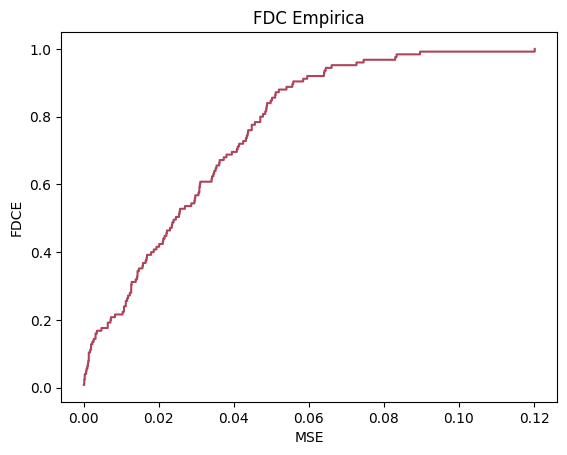

In [26]:
import statsmodels.api as sm

# Calcular la ECDF
ecdf = sm.distributions.ECDF(mse_e_values)

# Valores para la gráfica
edcf_x = np.linspace(min(mse_e_values), max(mse_e_values), num=1000)
edcf_y = ecdf(edcf_x)
print(edcf_y)

# Graficar la FDCE
plt.step(edcf_x, edcf_y, where='post', color='#AE445A')
plt.xlabel('MSE')
plt.ylabel('FDCE')
plt.title('FDC Empirica')
plt.show()

In [27]:
# from tempfile import TemporaryFile
# outfile = TemporaryFile()

np.save('distribuciones/ACTINVRB/DWT_NARNN.npy', edcf_y)

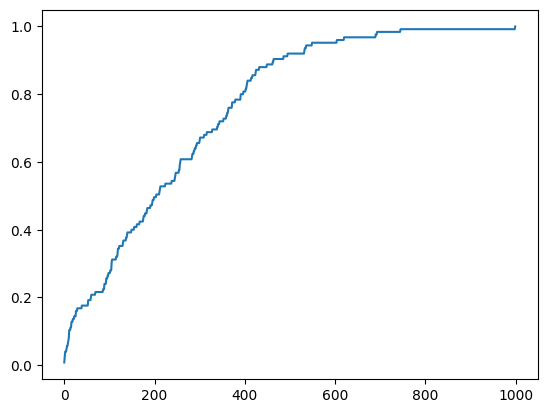

In [28]:
plt.plot(edcf_y)